In [1]:
library(tidyverse)
library(ggplot2)
library(data.table)
library(patchwork)
library(ggnewscale)
library(scales)
library(quantreg)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘packag

In [2]:
annot_map = read_tsv("results/simulated_data/sweeps/annot_overlap_ensembl_havana_104_exons_chr1_100.tsv")

Rows: 100 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, annot
dbl (3): sim_left, sim_right, overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rec_map = read_tsv("results/simulated_data/sweeps/rec_map_chr1_100.tsv", col_names=c("sim_left", "sim_right", "cM", "center_cM"))
rec_map$chrom = "chr1"

Rows: 100 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (4): sim_left, sim_right, cM, center_cM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
rec_map[rec_map$cM<0.001,]

sim_left,sim_right,cM,center_cM,chrom
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
121990000,126990000,0,0,chr1
124428689,129428689,0,0,chr1
126867378,131867378,0,0,chr1
129306067,134306067,0,0,chr1
131744756,136744756,0,0,chr1
134183445,139183445,0,0,chr1
136622134,141622134,0,0,chr1


In [5]:
ptm <- proc.time()
all_df = fread("results/simulated_data/sweeps/all_sims.stats.tsv")
proc.time() - ptm


   user  system elapsed 
  3.486   0.221   3.729 

In [6]:
all_df[all_df$annot=="",]$annot = " "

In [7]:
annot_labels <- c(`ensembl_havana_104_exons` = "Exons", " "="")
stat_labels <- c(`clr` = "logCLR",
                `diploshic` = "diploSHIC",
                `div` = "Diversity")
model_labels <- c(`neutral` = "Neutral",
                  `bgs` = "BGS",
                  `sweep` = "Sweep")

In [8]:
#all_df[all_df$annot=="ensembl_havana_104_exons",]$annot = "Exons"

In [9]:
#all_df$stat_name = factor(all_df$stat_name, labels=c("logCLR","diploSHIC", "Diversity"))

In [10]:
df = all_df
df[df$stat_name=="div",]$stat_val = max(df[df$stat_name=="div",]$stat_val, na.rm=T)-df[df$stat_name=="div",]$stat_val
df$sw_loc = (df$sim_left + df$sim_right)/2
df = left_join(df, rec_map)
df[df$center_cM < 0.001,]$stat_val = NA
df[df$stat_name=="clr",]$stat_val = log10(df[df$stat_name=="clr",]$stat_val+1e-5) # transforming CLR for visualization purposes

Joining with `by = join_by(chrom, sim_left, sim_right)`


In [11]:
table(df$model)


    bgs neutral   sweep 
1840000 1840000 3680075 

In [12]:
set.seed(1372)
sampled_locs = sample(unique(df[!is.na(df$stat_val),]$sim_left), 3)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


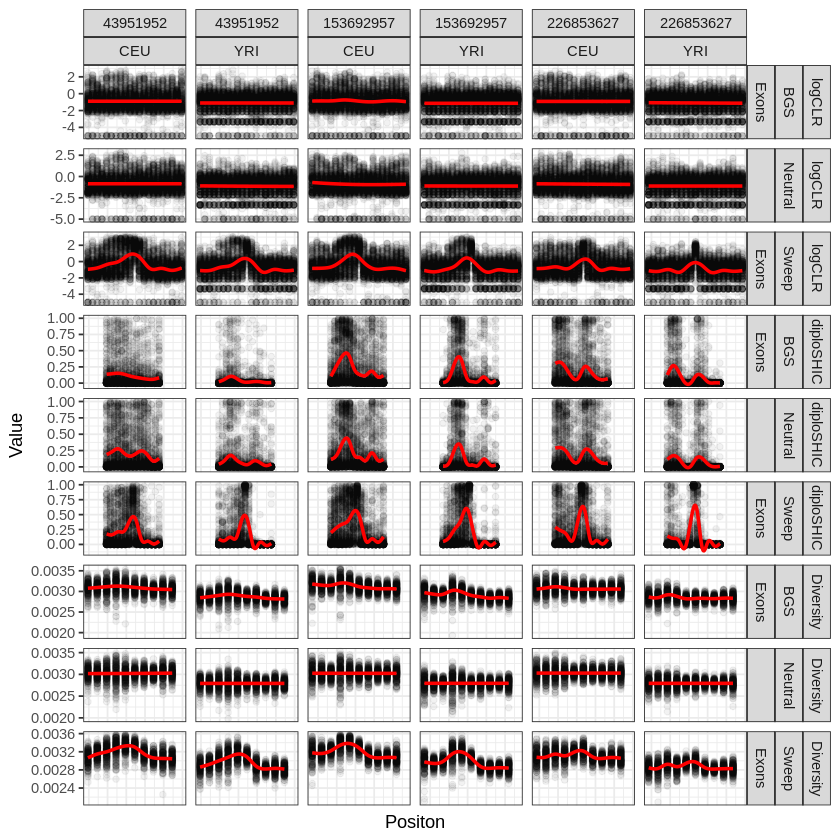

In [13]:
ggplot(df[!(df$model=="sweep" & df$annot == " ") & df$sim_left %in% sampled_locs,], aes(x=stat_left, y=stat_val)) +
    geom_point(alpha=0.05)+ 
    facet_grid(stat_name+model+annot~sim_left+pop, scales="free", labeller=labeller(annot=annot_labels, stat_name=stat_labels, model=model_labels)) + 
    geom_smooth(col="red") + 
    theme_bw() + 
    labs(y="Value", x="Positon") +
    theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
ggsave(paste0("results/simulated_data/sweeps/stats_sampled_locations.pdf"), width=7.5, height=11, scale=1.5)

In [14]:
#df[!(df$model=="sweep" & df$annot == " ") & df$sim_left %in% sampled_locs[1] & df$pop=="YRI" & df$seed==1501552846 & df$stat_name=="diploshic",]

In [15]:
# just keeping the central subwindow
df_sub = df %>%
    group_by(pop,model,demo,chrom,sim_left,annot,dfe,coeff,tmult,seed,stat_name) %>%
    filter(sw_loc >= stat_left, sw_loc < stat_right) %>%
    arrange(pop,model,annot,dfe,coeff,tmult)

In [16]:
df %>%
    group_by(pop,model,demo,chrom,sim_left,annot,dfe,coeff,tmult, stat_name) %>%
    filter(sw_loc >= stat_left, sw_loc < stat_right) %>%
    group_by(stat_name,pop,model,demo,chrom,annot,dfe,coeff,tmult) %>%
    summarize(mean = mean(stat_val, na.rm=TRUE))

`summarise()` has grouped output by 'stat_name', 'pop', 'model', 'demo',
'chrom', 'annot', 'dfe', 'coeff'. You can override using the `.groups`
argument.


stat_name,pop,model,demo,chrom,annot,dfe,coeff,tmult,mean
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
clr,CEU,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_K17,NA,NA,-0.849584843
clr,CEU,neutral,OutOfAfrica_3G09,chr1,,,NA,NA,-0.921160999
clr,CEU,sweep,OutOfAfrica_3G09,chr1,,,0.03,1,1.358140355
clr,CEU,sweep,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_K17,0.03,1,1.348518092
clr,YRI,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_K17,NA,NA,-1.098935569
clr,YRI,neutral,OutOfAfrica_3G09,chr1,,,NA,NA,-1.107294014
clr,YRI,sweep,OutOfAfrica_3G09,chr1,,,0.03,1,1.424466441
clr,YRI,sweep,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_K17,0.03,1,1.425056827
diploshic,CEU,bgs,OutOfAfrica_3G09,chr1,ensembl_havana_104_exons,Gamma_K17,NA,NA,0.135990455


In [17]:
global_neut_q5s = df[df$model == "neutral" & df$center_cM > 0.001,] %>% group_by(pop, stat_name) %>% summarize(neut_q5 = as.vector(quantile(stat_val, c(0.95), na.rm=T)))
global_bgs_q5s = df[df$model == "bgs" & df$center_cM > 0.001,] %>% group_by(pop, stat_name) %>% summarize(bgs_q5 = as.vector(quantile(stat_val, c(0.95), na.rm=T)))
df_sub = left_join(df_sub, global_neut_q5s)
df_sub = left_join(df_sub, global_bgs_q5s)
global_neut_q5s
global_bgs_q5s

`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
Joining with `by = join_by(pop, stat_name)`
Joining with `by = join_by(pop, stat_name)`


pop,stat_name,neut_q5
<chr>,<chr>,<dbl>
CEU,clr,1.298899122
CEU,diploshic,0.900140000
CEU,div,0.003242860
YRI,clr,0.578835687
YRI,diploshic,0.608201000
YRI,div,0.002973311


pop,stat_name,bgs_q5
<chr>,<chr>,<dbl>
CEU,clr,1.50051105
CEU,diploshic,0.84524100
CEU,div,0.00328037
YRI,clr,0.73056507
YRI,diploshic,0.41264500
YRI,div,0.00302982


Warning message:
“Removed 9200 rows containing non-finite values (`stat_quantile()`).”
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Warning message:
“Removed 9200 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 9200 rows containing non-finite values (`stat_quantile()`).”
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Warning message:
“Removed 9200 rows containing missing values (`geom_point()`).”


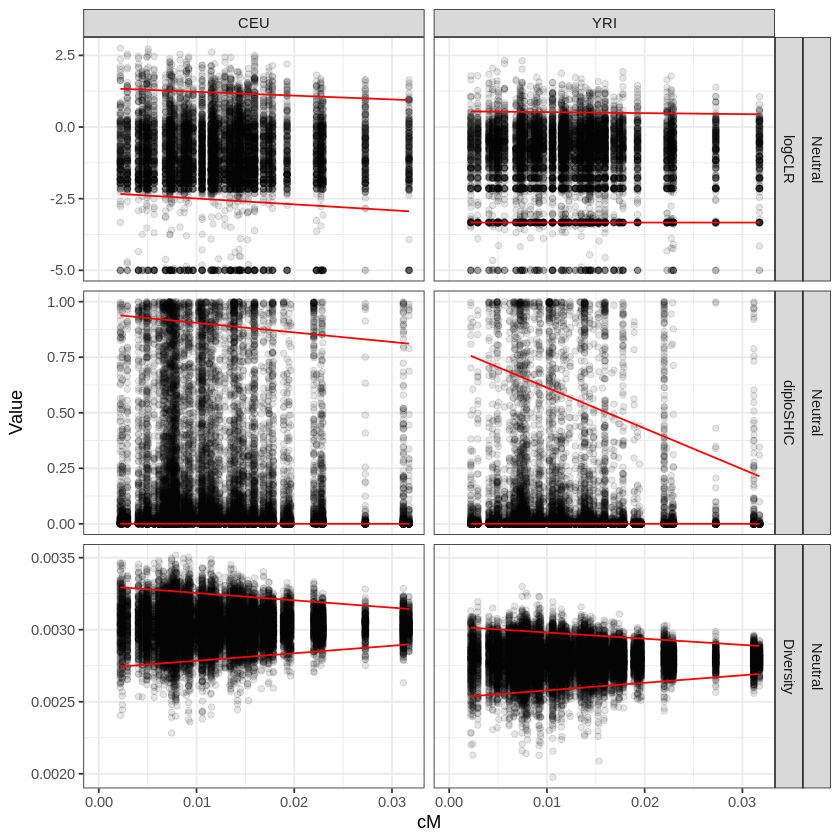

In [18]:
ggplot(df_sub[df_sub$model %in% c("neutral"),], aes(x = center_cM, y=stat_val)) +
    geom_point(alpha=0.1) +
    facet_grid(model+stat_name~pop, scale="free", labeller=labeller(stat_name=stat_labels, model=model_labels)) +
    stat_quantile(quantiles = c(0.05, 0.95), colour="red") +
    theme_bw() +
    labs(x="cM", y="Value")
ggsave(paste0("results/simulated_data/sweeps/neutral_relationship_stat-vals_cM.pdf"), width=9.5, height=9.5, scale=1.)

Warning message:
“Removed 18400 rows containing non-finite values (`stat_quantile()`).”
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Warning message:
“Removed 18400 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 18400 rows containing non-finite values (`stat_quantile()`).”
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Warning message:
“Removed 18400 rows containing missing values (`geom_point()`).”


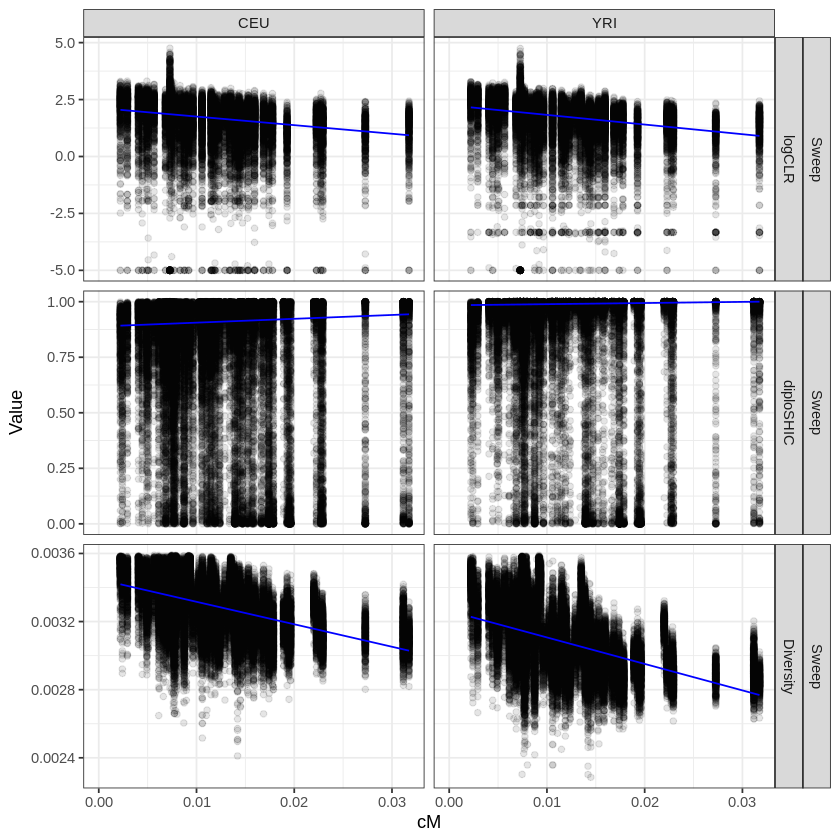

In [19]:
ggplot(df_sub[df_sub$model %in% c("sweep"),], aes(x = center_cM, y=stat_val)) +
    geom_point(alpha=0.1) +
    facet_grid(model+stat_name~pop, scale="free", labeller=labeller(stat_name=stat_labels, model=model_labels)) +
    stat_quantile(quantiles = c(0.5), colour="blue") +
    theme_bw() +
    labs(x="cM", y="Value")
ggsave(paste0("results/simulated_data/sweeps/sweep_relationship_stat-vals_cM.pdf"), width=9.5, height=9.5, scale=1.)

In [20]:
#df_sub %>% arrange(model, sim_left, pop)

In [21]:
#df_sub[df_sub$model == "neutral",] %>% group_by(sim_left, pop) %>% summarize(q5 = quantile(stat_val, c(0.05), na.rm=T), num=n())

In [22]:
df_sub$neut_is_neg = df_sub$stat_val < df_sub$neut_q5
df_sub$bgs_is_neg = df_sub$stat_val < df_sub$bgs_q5

In [23]:
sub_summary = df_sub %>% group_by(stat_name,sim_left, model, annot, pop, coeff) %>% summarise(neut_num_neg = sum(neut_is_neg),bgs_num_neg = sum(bgs_is_neg), total=n())
sub_summary$neut_nr = sub_summary$neut_num_neg / sub_summary$total
sub_summary$neut_pr = 1-sub_summary$neut_nr
sub_summary$bgs_nr = sub_summary$bgs_num_neg / sub_summary$total
sub_summary$bgs_pr = 1-sub_summary$bgs_nr
sub_summary = left_join(sub_summary, rec_map)
sub_summary = left_join(sub_summary, annot_map)

`summarise()` has grouped output by 'stat_name', 'sim_left', 'model', 'annot',
'pop'. You can override using the `.groups` argument.
Joining with `by = join_by(sim_left)`
Joining with `by = join_by(sim_left, annot, sim_right)`


In [24]:
p1_df = sub_summary[sub_summary$model=="sweep" & sub_summary$annot!="",] # just looking at the sims with sweeps and BGS
p1_df =  p1_df %>%
    select(stat_name:coeff, neut_pr, bgs_pr, sim_right, cM, center_cM, chrom, overlap) %>%
    pivot_longer(neut_pr:bgs_pr, names_pattern="(.*)_pr")
p1_df$name[p1_df$name=="neut"] = "Neutral"
p1_df$name[p1_df$name=="bgs"] = "BGS"

In [25]:
colpal = c('#D41159','#1A85FF')

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 184 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 184 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 184 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 184 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_smooth()`).”


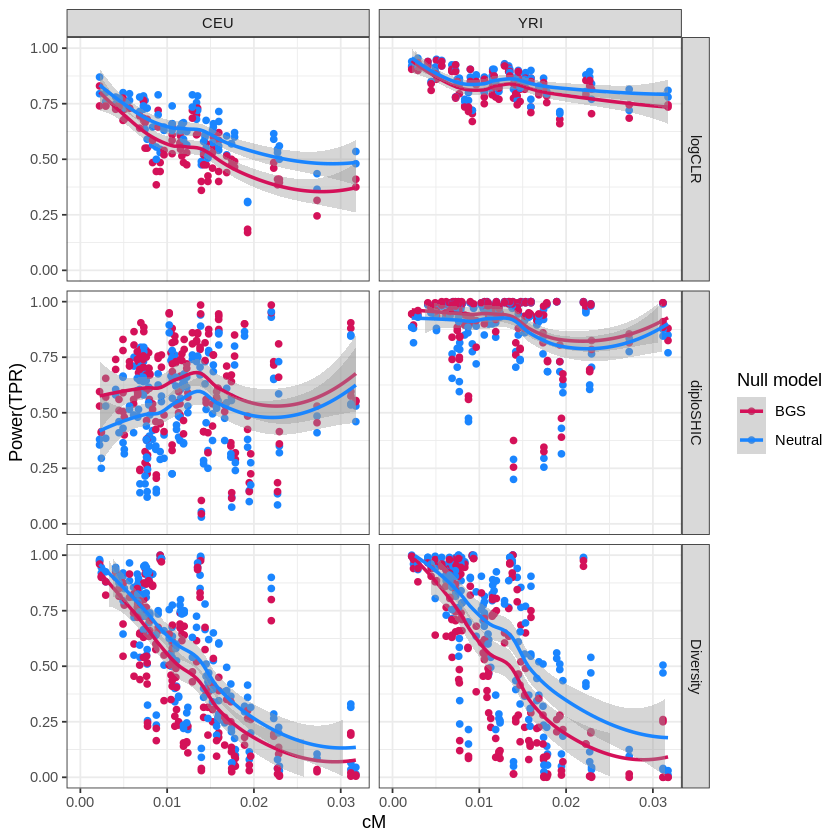

In [26]:
p1_df %>% ggplot(aes(y=value,x=center_cM, col=name)) +
    geom_point() +
    facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_smooth() + 
    ylim(0,1) + 
    scale_colour_manual(values =colpal)+
    labs(x="cM",y="Power(TPR)", col="Null model")+
    theme_bw()
ggsave(paste0("results/simulated_data/sweeps/relationship_power_cM.pdf"), width=9.5, height=9.5, scale=1.)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 1092 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1092 rows containing missing values (`geom_point()`).”


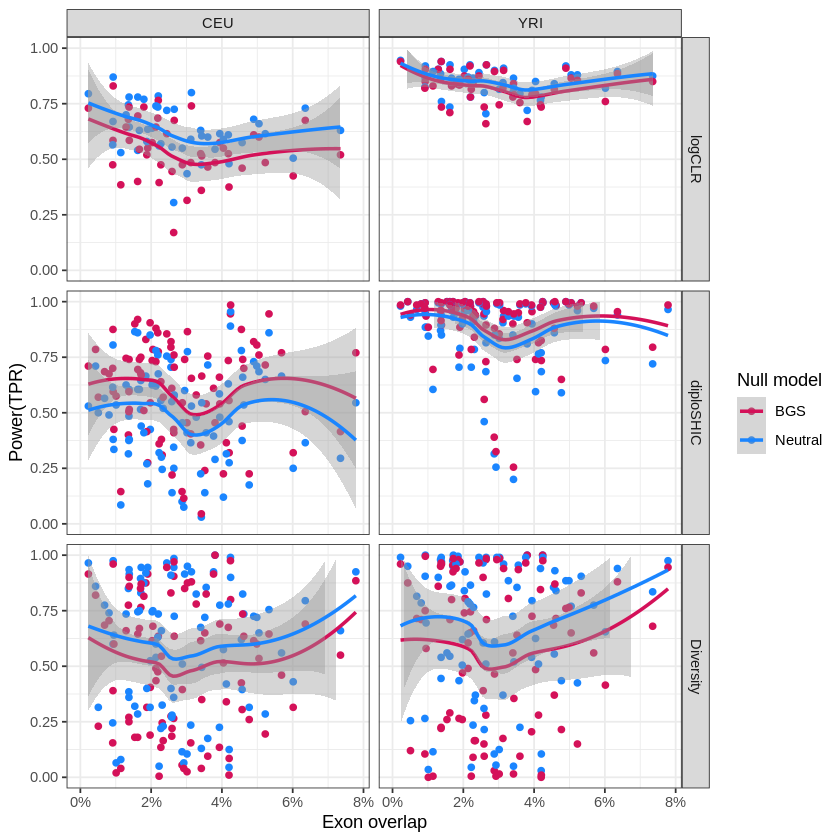

In [34]:
p1_df %>% ggplot(aes(y=value,x=overlap, col=name)) +
    geom_point() +
    facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_smooth() + 
    ylim(0,1) + 
    scale_colour_manual(values =colpal)+
    scale_x_continuous(labels = scales::percent) +
    labs(x="Exon overlap",y="Power(TPR)", col="Null model")+
    theme_bw()

In [32]:
ggsave(paste0("results/simulated_data/sweeps/relationship_power_exon.pdf"), width=9.5, height=9.5, scale=1.)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 1092 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1092 rows containing missing values (`geom_point()`).”


In [28]:
p1 = ggplot(p1_df, aes(y=value, x=sim_left)) + 
    geom_line(aes(col=name)) + facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.05, ymax=0.00, fill=center_cM))+ labs(fill="cM")+
    scale_fill_viridis_c(option="D") +
    new_scale_fill() +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.1, ymax=-.05, fill=overlap))+
    scale_fill_viridis_c(option="B", labels=label_percent()) +
    labs(x="Position", y="Power (TPR)", col="Null model", fill="Exon overlap") +
    theme_bw() + ylim(-0.1,1) + scale_colour_manual(values =colpal)

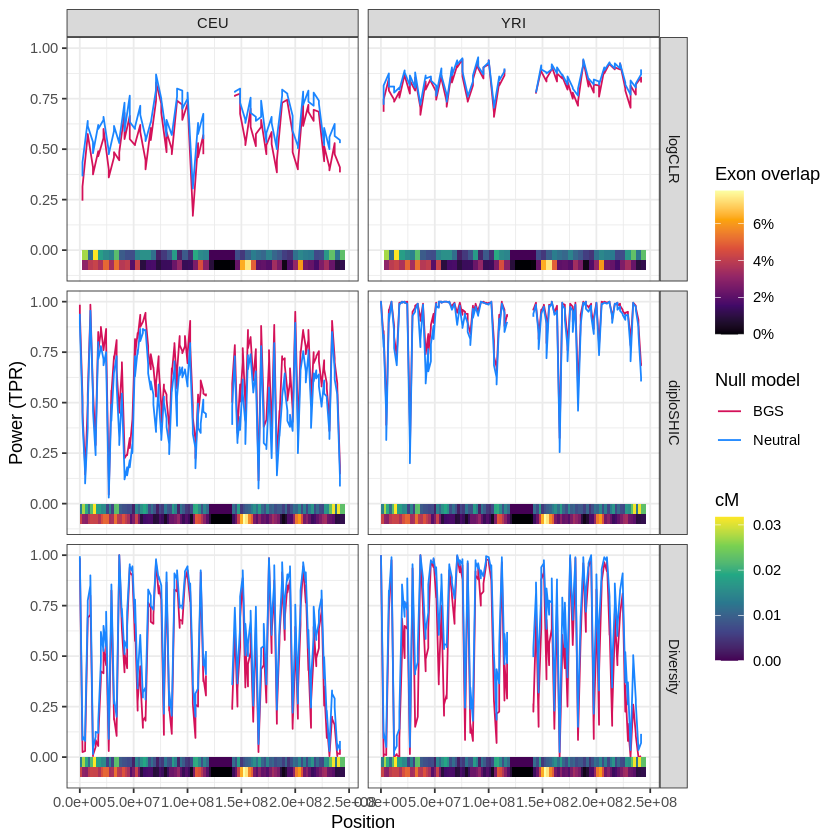

In [29]:
p1
ggsave(paste0("results/simulated_data/sweeps/chr1_power.pdf"), width=8.5, height=11)